In this notebook we make the figure with all the target spectra


In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn import preprocessing
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc
import csaps

import sys, errno  


In [2]:

palette = sns.color_palette()
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 13
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'
one_col = 85 *0.0393701
two_col = 170*0.0393701

In [3]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
ppath = f'{letter_drive}:/AFKABAN/Pcod_190123/select/'
p2path = f'{letter_drive}:/AFKABAN/Pcod2_240123/select/'
apath = f'{letter_drive}:/AFKABAN/Acod_200123/select/'
pbpath = f'{letter_drive}:/AFKABAN/Pandalus_260123/select/'
hpath = f'{letter_drive}:/AFKABAN/BroadbandHerring'
WBATpath = f'{letter_drive}:/AFKABAN/WBAT_data_PNC2023/'

In [4]:
a_tilt_df = pd.read_feather(f'{apath}/a_tilt_df.feather')
p_tilt_df = pd.read_feather(f'{ppath}/p_tilt_df.feather')
p2_tilt_df = pd.read_feather(f'{p2path}/p2_tilt_df.feather')
pb_tilt_df = pd.read_feather(f'{pbpath}/pb_tilt_df.feather')
h_120_df = pd.read_feather(f'{hpath}/herring_interp_120.feather')
h_200_df = pd.read_feather(f'{hpath}/herring_interp_200.feather')
WBAT_tilt_df = pd.read_feather(f'{WBATpath}/WBAT_tilt_df.feather')


# Find relevant frequencies

## Plot

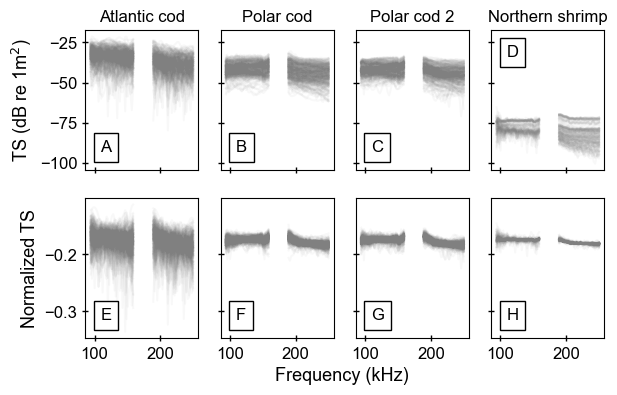

In [5]:
df_list = [a_tilt_df,p_tilt_df,p2_tilt_df,pb_tilt_df]
name_list = ['Atlantic cod', 'Polar cod', 'Polar cod 2', 'Northern shrimp']
fig,ax = plt.subplots(2,4, figsize=(two_col,4), sharex=True, sharey='row')
c_list=[1,2,0,3]

# Record number of entries for each species with first value as 0
N_120 = np.zeros(len(df_list)+1)
N_200 = np.zeros(len(df_list)+1)

for i_df in range(len(df_list)):
    # calculate median tilt for intervals of 10 degrees tilt
    df = df_list[i_df]
    
    #plot 120
    
    ind_120 = np.where(np.isnan(df['201.129']))[0]
    
    ts_s1 = np.where(df.columns.values=='94.032')[0][0]
    ts_e1 = np.where(df.columns.values=='158.548')[0][0]

    df_ts_120 = df.iloc[ind_120,ts_s1:ts_e1+1]
    
    # Normalizer
    mm_norm = preprocessing.Normalizer(norm='l2')
    df_norm_120 = mm_norm.fit_transform(df_ts_120)
    
    if i_df == 0:
        df_ts_120_all = df_ts_120
    else: 
        df_ts_120_all = pd.concat([df_ts_120_all, df_ts_120], ignore_index=True)
    
    N_120[i_df+1] = len(df_ts_120)
    
    freqs_120 = df_ts_120.columns.unique().values.astype(np.float64)
    # Plot three TS
    ax[0, i_df].plot(freqs_120, df_ts_120.T, c = 'grey', alpha=0.05)
    ax[1, i_df].plot(freqs_120, df_norm_120.T, c = 'grey', alpha=0.05)

    
    
    # plot 200
    ind_200 = np.where(np.isnan(df['120.242']))[0]
    
    ts_s2 = np.where(df.columns.values=='189.032')[0][0]
    ts_e2 = np.where(df.columns.values=='249.516')[0][0]

    df_ts_200 = df.iloc[ind_200,ts_s2:ts_e2+1]
    
    # Normalizer
    mm_norm = preprocessing.Normalizer(norm='l2')
    df_norm_200 = mm_norm.fit_transform(df_ts_200)
    
    if i_df == 0:
        df_ts_200_all = df_ts_200
    else: 
        df_ts_200_all = pd.concat([df_ts_200_all, df_ts_200], ignore_index=True)
    
    
    N_200[i_df+1] = len(df_ts_200)
    
    freqs_200 = df_ts_200.columns.unique().values.astype(np.float64)
    ax[0, i_df].plot(freqs_200, df_ts_200.T, c = 'grey', alpha=0.05)
    ax[1, i_df].plot(freqs_200,df_norm_200.T, c = 'grey', alpha=0.05)
    
    
    ax[0, i_df].set_title(name_list[i_df])
    
    
    
# # MinMaxScaler Runs on entire daatset *test but will look like this*

# # Scaler
# mm_scaler = preprocessing.MinMaxScaler()
# df_scaler_120 = mm_scaler.fit_transform(df_ts_120_all)

# #Scaler
# mm_scaler = preprocessing.MinMaxScaler()
# df_scaler_200 = mm_scaler.fit_transform(df_ts_200_all)
    
    
# for i_df in range(len(df_list)):
#     # calculate median tilt for intervals of 10 degrees tilt
#     df = df_list[i_df]
    
#     ind_120 = np.cumsum(N_120)
#     ind_200 = np.cumsum(N_200)
    
#     ax[2, i_df].plot(freqs_120, df_scaler_120[int(ind_120[i_df]):int(ind_120[i_df+1]),:].T, c = 'grey', alpha=0.05)
#     ax[2, i_df].plot(freqs_200, df_scaler_200[int(ind_200[i_df]):int(ind_200[i_df+1]),:].T, c = 'grey', alpha=0.05)
    
    
# Set panel labels
letter =['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', ]
axes = ax.flatten()
for panel_i in range(len(letter)):
    if panel_i == 3:
        at = AnchoredText(letter[panel_i], loc='upper left')
        axes[panel_i].add_artist(at)
    else:
        at = AnchoredText(letter[panel_i], loc='lower left')
        axes[panel_i].add_artist(at)

ax[0,0].set_ylabel('TS (dB re 1m$^2$)')
ax[1,0].set_ylabel('Normalized TS')
ax[1,1].set_xlabel('                          Frequency (kHz)')
    #axes[i_df].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=13)
    
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN/TargetSpectra_Norm.jpeg', format='jpeg', dpi = 600, facecolor='w', bbox_inches='tight', transparent=True)

## Add WBAT

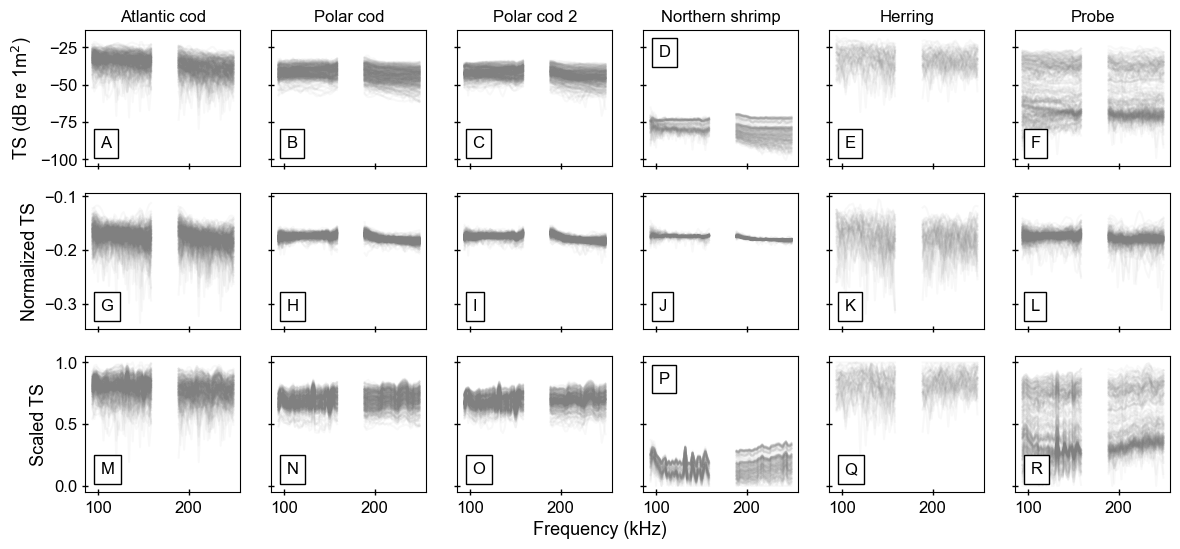

In [6]:
df_list = [a_tilt_df,p_tilt_df,p2_tilt_df,pb_tilt_df, h_120_df, WBAT_tilt_df]
name_list = ['Atlantic cod', 'Polar cod', 'Polar cod 2', 'Northern shrimp', 'Herring', 'Probe']
fig,ax = plt.subplots(3,6, figsize=(14,6), sharex=True, sharey='row')

# Record number of entries for each species with first value as 0
N_120 = np.zeros(len(df_list)+1)
N_200 = np.zeros(len(df_list)+1)

for i_df in range(len(df_list)):
    # calculate median tilt for intervals of 10 degrees tilt
    df = df_list[i_df]
    
    #plot 120
    if i_df == 4:
        df_ts_120 = h_120_df.iloc[:,:-1]
        df_ts_200 = h_200_df.iloc[:,:-1]
    else:
       # prep 120
        ind_120 = np.where(np.isnan(df['201.129']))[0]

        ts_s1 = np.where(df.columns.values=='94.032')[0][0]
        ts_e1 = np.where(df.columns.values=='158.548')[0][0]

        df_ts_120 = df.iloc[ind_120,ts_s1:ts_e1+1]
        
    # prep 200
        ind_200 = np.where(np.isnan(df['120.242']))[0]

        ts_s2 = np.where(df.columns.values=='189.032')[0][0]
        ts_e2 = np.where(df.columns.values=='249.516')[0][0]

        df_ts_200 = df.iloc[ind_200,ts_s2:ts_e2+1]
    
    
    if i_df == 0:
        df_ts_120_all = df_ts_120
    else: 
        df_ts_120_all = pd.concat([df_ts_120_all, df_ts_120], ignore_index=True)
    
    N_120[i_df+1] = len(df_ts_120)
    
        # Normalizer
    mm_norm = preprocessing.Normalizer(norm='l2')
    df_norm_120 = mm_norm.fit_transform(df_ts_120)
    

    # Normalizer
    mm_norm = preprocessing.Normalizer(norm='l2')
    df_norm_200 = mm_norm.fit_transform(df_ts_200)
    
    if i_df == 0:
        df_ts_200_all = df_ts_200
    else: 
        df_ts_200_all = pd.concat([df_ts_200_all, df_ts_200], ignore_index=True)
    
    
    N_200[i_df+1] = len(df_ts_200)
    
    # Plott
    
    freqs_120 = df_ts_120.columns.unique().values.astype(np.float64)
    # Plot three TS
    ax[0, i_df].plot(freqs_120, df_ts_120.T, c = 'grey', alpha=0.05)
    ax[1, i_df].plot(freqs_120, df_norm_120.T, c = 'grey', alpha=0.05)
    
    
    freqs_200 = df_ts_200.columns.unique().values.astype(np.float64)
    ax[0, i_df].plot(freqs_200, df_ts_200.T, c = 'grey', alpha=0.05)
    ax[1, i_df].plot(freqs_200,df_norm_200.T, c = 'grey', alpha=0.05)
    
    
    ax[0, i_df].set_title(name_list[i_df])
    
    
    
# MinMaxScaler Runs on entire daatset *test but will look like this*

# Scaler
mm_scaler = preprocessing.MinMaxScaler()
df_scaler_120 = mm_scaler.fit_transform(df_ts_120_all)

#Scaler
mm_scaler = preprocessing.MinMaxScaler()
df_scaler_200 = mm_scaler.fit_transform(df_ts_200_all)
    
    
for i_df in range(len(df_list)):
    # calculate median tilt for intervals of 10 degrees tilt
    df = df_list[i_df]
    
    ind_120 = np.cumsum(N_120)
    ind_200 = np.cumsum(N_200)
    
    ax[2, i_df].plot(freqs_120, df_scaler_120[int(ind_120[i_df]):int(ind_120[i_df+1]),:].T, c = 'grey', alpha=0.05)
    ax[2, i_df].plot(freqs_200, df_scaler_200[int(ind_200[i_df]):int(ind_200[i_df+1]),:].T, c = 'grey', alpha=0.05)
    
    
# Set panel labels
letter =['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L','M','N','O', 'P', 'Q', 'R']
axes = ax.flatten()
for panel_i in range(len(letter)):
    if panel_i in {3, 15}:
        at = AnchoredText(letter[panel_i], loc='upper left')
        axes[panel_i].add_artist(at)
    else:
        at = AnchoredText(letter[panel_i], loc='lower left')
        axes[panel_i].add_artist(at)

ax[0,0].set_ylabel('TS (dB re 1m$^2$)')
ax[1,0].set_ylabel('Normalized TS')
ax[2,0].set_ylabel('Scaled TS')
ax[2,2].set_xlabel('                          Frequency (kHz)')
    #axes[i_df].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=13)
    
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN/TargetSpectra_wProbe.jpeg', format='jpeg', dpi = 600, facecolor='w', bbox_inches='tight', transparent=True)

What does figure say:

- Both polar cod experiments match. Duplicable?
- Atlantic cod target spectra is more complex. More nulls and variability
- Polar cod and northern shrimp also have intensity variability but mostly consistent shape. Which seems to be "calibration" driven?
- Northern shrimp has a large distribution of intensity with 200 kHz.

### number of SED in tracks for each bandwidth

In [7]:
for panel_i in range(0,4):
    df = df_list[panel_i]
    species = name_list[panel_i]

    ts_s = np.where(df.columns.values=='98.065')[0][0]
    ts_e = np.where(df.columns.values=='191.048')[0][0]
    
    n_120 = np.sum(~np.isnan(df.iloc[:,ts_s]))
    n_200 = np.sum(~np.isnan(df.iloc[:,ts_e]))
    
    n_tracks = len(df.Region_name.unique())
    
    print(f'{species}: There are {n_120} SED in the 120 kHz bandwidth and {n_200} SED in the 200 kHz bandwidth in {n_tracks} tracks')

Atlantic cod: There are 345 SED in the 120 kHz bandwidth and 273 SED in the 200 kHz bandwidth in 60 tracks
Polar cod: There are 345 SED in the 120 kHz bandwidth and 362 SED in the 200 kHz bandwidth in 62 tracks
Polar cod 2: There are 350 SED in the 120 kHz bandwidth and 337 SED in the 200 kHz bandwidth in 66 tracks
Northern shrimp: There are 108 SED in the 120 kHz bandwidth and 180 SED in the 200 kHz bandwidth in 25 tracks



### Mean intensity of each species.

In [8]:
for panel_i in range(0,4):
    df = df_list[panel_i]
    species = name_list[panel_i]

    ts_lows = np.where(df.columns.values=='94.032')[0][0]
    ts_lowe = np.where(df.columns.values=='160.565')[0][0]
    
    ts_highs = np.where(df.columns.values=='189.032')[0][0]
    ts_highe = np.where(df.columns.values=='251.532')[0][0]
    
    n_120 = np.sum(np.nanmean(df.iloc[:,ts_lows:ts_lowe]))
    n_200 = np.sum(np.nanmean(df.iloc[:,ts_highs:ts_highe]))
    
    print(f'{species}: There are {n_120:.2f} SED in the 120 kHz bandwidth and {n_200:.2f} SED in the 200 kHz bandwidth')

Atlantic cod: There are -33.83 SED in the 120 kHz bandwidth and -38.47 SED in the 200 kHz bandwidth
Polar cod: There are -41.46 SED in the 120 kHz bandwidth and -43.77 SED in the 200 kHz bandwidth
Polar cod 2: There are -41.75 SED in the 120 kHz bandwidth and -44.19 SED in the 200 kHz bandwidth
Northern shrimp: There are -77.56 SED in the 120 kHz bandwidth and -81.81 SED in the 200 kHz bandwidth


### Maximum TS range at each nominal frequency

In [9]:
for panel_i in range(0,4):
    df = df_list[panel_i]
    species = name_list[panel_i]

    nom_120 = np.where(df.columns.values=='120.242')[0][0]
    
    nom_200 = np.where(df.columns.values=='201.129')[0][0]
    
    N_reg = len(df.Region_name.unique())
    range_120 = np.zeros(N_reg)
    range_200 = np.zeros(N_reg)
    for i in range(N_reg):
        df_reg = df[df['Region_name']==df.Region_name.unique()[i]]
    
        range_120[i] = np.max(df_reg.iloc[:,nom_120]) - np.min(df_reg.iloc[:,nom_120])
        range_200[i] = np.max(df_reg.iloc[:,nom_200]) - np.min(df_reg.iloc[:,nom_200])
    
    print(f'{species}: The max range is {np.nanmax(range_120):.2f} dB re 1m^2 at 120 kHz and {np.nanmax(range_200):.2f} dB re 1m^2 at 200 kHz.')
    
    #print(f'{species}: The mean range is {np.mean(range_120):.2f} dB re 1m^2 at 120 kHz and {np.nanmean(range_200):.2f} dB re 1m^2 at 200 kHz.')

Atlantic cod: The max range is 43.48 dB re 1m^2 at 120 kHz and 32.69 dB re 1m^2 at 200 kHz.
Polar cod: The max range is 16.80 dB re 1m^2 at 120 kHz and 19.78 dB re 1m^2 at 200 kHz.
Polar cod 2: The max range is 13.69 dB re 1m^2 at 120 kHz and 21.12 dB re 1m^2 at 200 kHz.
Northern shrimp: The max range is 7.22 dB re 1m^2 at 120 kHz and 8.55 dB re 1m^2 at 200 kHz.
